***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 06/01}}$<br>

#### Note sw: Switching -> CO<->O2 ; CO*<->O* To match KMC specnum file


#### It also |uses the MKM input files that match this order *_sw

#### As well as the new test set KMC_NonDynamic_Data_iCovg_iRates_sw

#### Switch the pressures accordingly CO <-> O2

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Comparison_KMC_Non_Vs_Lateral'

In [3]:
%%time
# Sim_folder_names_non = []
# i = 0
# for file in glob.glob("Sim_*_Non"):
#     Sim_folder_names_non.append(file)
#     i+=1
# print('Number of simulations:',i)
# print(Sim_folder_names_non)
#^ SINCE WE NEED TO MAKE SURE THE ORDER MATCHES

Sim_folder_names_non = ['Sim_A_0_B_100_Non','Sim_A_100_B_0_Non','Sim_A_0_B_0_Non','Sim_A_44_B_44_Non']


#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [4]:
%%time
# Sim_folder_names_lat = []
# i = 0
# for file in glob.glob("Sim_*_Lat"):
#     Sim_folder_names_lat.append(file)
#     i+=1
# print('Number of simulations:',i)
# print(Sim_folder_names_lat)


Sim_folder_names_lat = ['Sim_A_0_B_100_Lat','Sim_A_100_B_0_Lat','Sim_A_0_B_0_Lat','Sim_A_44_B_44_Lat']

#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [5]:
set_init_coverages = np.empty([len(Sim_folder_names_lat),4])
#Remember: A='O*'; B='CO*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names_lat:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter

In [6]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Comparison_KMC_Non_Vs_Lateral'

In [7]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n_points = 500 #From KMC simulation 
n_gas_species = 3 #From KMC simulation
n_surf_species = 4 #From KMC simulation

Exp_init_coverages = np.empty([len(Sim_folder_names_lat),n_surf_species])
c = 0 #counter
for s in Sim_folder_names_lat:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    exp_init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        exp_init_covg.append(Scoverages[0,i])
        
    Exp_init_coverages[c,:] = exp_init_covg
    
    c+=1
    
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

<a id="1.1"></a> 
## 1.1 Checking all simulations were completed as expected
<a href="#top">Back to top</a>

In [8]:
if np.shape(set_init_coverages) != np.shape(Exp_init_coverages):
    raise Exception('Not all simulations have been completed successfully')
    
for i in np.arange(np.shape(set_init_coverages)[0]):
    for j in np.arange(np.shape(set_init_coverages)[1]):
        norm_val = set_init_coverages[i,j]
        exp_val = round(Exp_init_coverages[i,j])
        if not( norm_val + 1 > exp_val) and not(norm_val - 1 < exp_val): #i.e if not within range
            raise Exception('Initial coverages used in the simulation are not the same as it was set')
            
        if (i==(np.shape(set_init_coverages)[0] - 1) and j==(np.shape(set_init_coverages)[1] - 1)):
            print('SIMULATIONS MATCH AS EXPECTED')

SIMULATIONS MATCH AS EXPECTED


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [9]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

## FOR NON LATERAL

In [10]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='O*'; B='CO*'
n = len(Sim_folder_names_non)

Covg = np.zeros((n,n_points,n_surf_species)) #O*, CO*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names_non:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    
    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []
    
    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])
        
    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)
    
    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])
        
    init_coverages[c,:]= init_covg #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict_NON_LAT = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 141 ms, sys: 2.87 ms, total: 144 ms
Wall time: 148 ms


## FOR LATERAL

In [11]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='O*'; B='CO*'
n = len(Sim_folder_names_lat)

Covg = np.zeros((n,n_points,n_surf_species)) #CO*, O*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names_lat:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    
    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []
    
    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])
        
    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)
    
    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])
        
    init_coverages[c,:]= init_covg #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict_LAT = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 136 ms, sys: 1.6 ms, total: 138 ms
Wall time: 137 ms


## Starting to Create ML dataset
### x:n_features ; y = n_points ; z = n_simulations

<a id="2.4"></a> 
## 2.D  Creating Input/Feature Tensor
<a href="#top">Back to top</a>

In [12]:
%%time
## Creating Simulation file names input

#----------------------------------------------------------------------------------------------
Sim_names_tens_non = np.empty((n,n_points,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(n_points):
        Sim_names_tens_non[i,j,:] = Sim_folder_names_non[i]
        
Sim_names_tens_lat = np.empty((n,n_points,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(n_points):
        Sim_names_tens_lat[i,j,:] = Sim_folder_names_lat[i]
#----------------------------------------------------------------------------------------------

## Creating Init coverages tensor input
ini_covg_tens_non = np.empty((n,n_points,n_surf_species),dtype=float)
for i in np.arange(n):
    for j in np.arange(n_points):
        ini_covg_tens_non[i,j,:] = data_KMC_dict_NON_LAT['init_covg'][i,:]
        
## Creating Init coverages tensor input
ini_covg_tens_lat = np.empty((n,n_points,n_surf_species),dtype=float)
for i in np.arange(n):
    for j in np.arange(n_points):
        ini_covg_tens_lat[i,j,:] = data_KMC_dict_LAT['init_covg'][i,:]
        
#----------------------------------------------------------------------------------------------
## Creating time tensor input
sim_time_tens_non = np.empty((n,n_points,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens_non[i,:,z] = data_KMC_dict_NON_LAT['sim_time'][i,:]
        
## Creating time tensor input
sim_time_tens_lat = np.empty((n,n_points,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens_lat[i,:,z] = data_KMC_dict_LAT['sim_time'][i,:]
        
#----------------------------------------------------------------------------------------------

CPU times: user 6.72 ms, sys: 1.02 ms, total: 7.73 ms
Wall time: 6.81 ms


## Tenosr_To_Array Function

In [13]:
def Tensor_To_Array(Sim_tens):
    a = Sim_tens
    m,n,r = a.shape
    sim_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
    return sim_arr

## Creating Dataframe

## DATAFRAME FOR NON LATERAL

In [14]:
out_df_non = pd.DataFrame(Tensor_To_Array(Sim_names_tens_non),columns= ['Sim_ndex','Sim_names'])
out_df_lat = pd.DataFrame(Tensor_To_Array(Sim_names_tens_lat),columns= ['Sim_ndex','Sim_names'])

In [15]:
#Adding initial coverages
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_non['Init_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(ini_covg_tens_non))[1+i]
    
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_lat['Init_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(ini_covg_tens_lat))[1+i]    

In [16]:
#Adding time
out_df_non['Time'] = pd.DataFrame(Tensor_To_Array(sim_time_tens_non))[1]
out_df_lat['Time'] = pd.DataFrame(Tensor_To_Array(sim_time_tens_lat))[1]

In [17]:
## Adding KMC results

In [18]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_non['KMC_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict_NON_LAT['covg_prof']))[1+i]
    
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_lat['KMC_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict_LAT['covg_prof']))[1+i]

In [19]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df_non['KMC_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict_NON_LAT['iRates']))[1+i]
    
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df_lat['KMC_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict_LAT['iRates']))[1+i]

In [20]:
## Replicating out_df_lat to create a datframe to containe MKM siumulation results accounting for coverage dependenc
#
#
out_df_lat_cd = out_df_lat

***
<a id="2.2"></a> 
## 2.B  Generating MF-MKModel Data Dictionary
<a href="#top">Back to top</a>

In [21]:
%%time
from main import *
MKM = MKModel('Atomic_sw.csv','Stoich_sw.csv','Param_sw.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*0.1),(1.0e-4*1.0e-5), 0]) #From KMC #Make sure it matches 02 CO CO2
MKM_init_coverages = np.empty([len(Sim_folder_names_non),n_surf_species])

def MKModelling(*fit_params,Sim_folder_names=Sim_folder_names_non, data_KMC_dict = data_KMC_dict_NON_LAT):
    n_points = 500 #From KMC simulation 
    n_gas_species = 3 #From KMC simulation
    n_surf_species = 4 #From KMC simulation
    MKM_Covg = np.zeros((n,n_points,n_surf_species)) # O*,CO*, O2*, * #Make sure KMC order of species matches MKM inputs
    MKM_Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2     #Make sure KMC order of species matches MKM inputs
    time_MKM_Array = np.zeros((n,n_points))

    MKM.set_limits_of_integration(Ti=data_KMC_dict['sim_time'][0][0],Tf=data_KMC_dict['sim_time'][-1][-1])
    
    MKM.k = np.array(fit_params)
    
    #Remember: A='O*'; B='CO*'
    #Reading A and B initial coverages from the KMC simulation input coverage file names!
    c = 0 #counter
    for s in Sim_folder_names:
        set_coverages = []
        for i in np.arange(len(s)):
            if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
                cov_triple = int(s[i:i+3])
                set_coverages.append(cov_triple)

            elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
                cov_double = int(s[i:i+2])
                set_coverages.append(cov_double)

            elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
                cov_single = int(s[i])
                set_coverages.append(cov_single)
                                    #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg  #Note: Special case: Simulation naming switches from KMC and MKM order
        init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]
        
        MKM.set_initial_coverages(init=init_covgs)
        MKM_init_coverages[c,:] = [float(i) for i in init_covgs]
        
        sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        time_MKM_Array[c,:]= solta #Time matrix
        MKM_Covg[c,:,:] = sola #Coverage profile tensor

        solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        MKM_Rates[c,:,:] = solb[:,0:n_gas_species] 

        c+=1 #counter
    return {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 293 ms, sys: 59.2 ms, total: 352 ms
Wall time: 466 ms


In [22]:
#Average
initial_vals = np.array([8.30E+02,5.58E-02,7.77E+06,1.04E+06,1.36E+05,1.79E-07,1.14E+00,0.00E+00])

In [23]:
#Max rates
# initial_vals = np.array([8.30E+02,7.47E-02,7.77E+06,2.05E+06,2.67E+05,3.58E-07,1.35E+00,0.00E+00])

In [24]:
#Min rates
# initial_vals = np.array([8.30E+02,3.69E-02,7.77E+06,3.49E+04,5.30E+03,7.33E-11,9.35E-01,0.00E+00])

In [25]:
#Mix rates _1 fwdmax, rvsmin
# initial_vals = np.array([8.30E+02,3.69E-02,7.77E+06,3.49E+04,2.67E+05,7.33E-11,1.35E+00,0.00E+00])

In [26]:
#Mix rates _2 fwdmin, rvsmax
# initial_vals = np.array([8.30E+02,7.47E-02,7.77E+06,2.05E+06,5.30E+03,3.58E-07,9.35E-01,0.00E+00])

In [27]:
#Mix rates _3 fwdmin, rvsavg
# initial_vals = np.array([8.30E+02,5.58E-02,7.77E+06,1.04E+06,5.30E+03,1.79E-07,9.35E-01,0.00E+00])

In [28]:
#Mix rates _4 fwdavg, rvsmin
# initial_vals = np.array([8.30E+02,3.69E-02,7.77E+06,3.49E+04,1.36E+05,7.33E-11,1.14E+00,0.00E+00])

***
<a id="2.3.1"></a> 
## 2.B.1 Optimizing Rate Constant:
<a href="#top">Back to top</a>

In [29]:
%%time
## Fitting rate constant function due to the feature = iRates
def MKM_k_fitting(x,*fit_params,feature = 'iRates'):
    data_MKM_dict  = MKModelling(*fit_params)    
    return np.reshape(data_MKM_dict[feature],data_MKM_dict[feature].size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [30]:
# %%time
x_values = data_KMC_dict_NON_LAT['sim_time'] #Normalized Input Time variables (Independent Variable) (eg. KMC Time)
y_values = np.reshape(data_KMC_dict_NON_LAT['iRates'],data_KMC_dict_NON_LAT['iRates'].size) #Normalized Input Dependent variable(s) (eg. KMC coverages)

# params, params_covariance = optimize.curve_fit(MKM_k_fitting, x_values, y_values
#                                             ,method = 'trf', bounds=(0,1e12), maxfev=3e3, xtol=1e-12, ftol=1e-12
#                                             ,p0=initial_vals)

In [31]:
params = initial_vals 

In [32]:
fit_params = params

In [33]:
%%time
MKM.ODE_Tolerances(Dplace=60,reltol=1e-9,abstol=1e-9)
data_MKM_dict_NON_LAT  = MKModelling(*fit_params,Sim_folder_names_non,data_KMC_dict=data_KMC_dict_NON_LAT)
data_MKM_dict_LAT  = MKModelling(*fit_params,Sim_folder_names_lat,data_KMC_dict=data_KMC_dict_LAT)

<timed exec>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 31.5 s, sys: 270 ms, total: 31.8 s
Wall time: 32.4 s


In [34]:
%%time
#Calculating Coverage Dependent case of MKM to be used to compare lateral interactions
# MKM.rate_const_correction='Forced_exp_CD'
data_MKM_dict_LAT_CD = MKModelling(*fit_params,Sim_folder_names_lat,data_KMC_dict=data_KMC_dict_LAT)

<timed exec>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 15.5 s, sys: 131 ms, total: 15.7 s
Wall time: 15.8 s


In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(y_values, np.reshape(data_MKM_dict_NON_LAT['iRates'],data_KMC_dict_NON_LAT['iRates'].size))))

Root Mean Squared Error:
 0.9355606769825464


In [36]:
MKM.ODE_Tolerances()

(50, 0.001, 0.001)

In [37]:
#From the KMC fitting attempt
##Perfect Fits
# params = np.array([5.60983514e+07, 6.26873886e-10, 2.09163588e+04, 8.74022929e+09, 1.03443448e+10, 2.75903622e-01, 1.03031697e+08, 5.00000000e+02])

In [38]:
# %%time
# MKM.ODE_Tolerances(Dplace=50,reltol=1e-5,abstol=1e-8)
# data_MKM_dict = MKModelling(*params)

***
<a id="2.3.2"></a> 
## Adding MKM to dataframe
<a href="#top">Back to top</a>

In [39]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_non['MKM_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_NON_LAT['covg_prof']))[1+i]
    
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_lat['MKM_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_LAT['covg_prof']))[1+i]    
    
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df_lat_cd['MKM_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_LAT_CD['covg_prof']))[1+i]    

In [40]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df_non['MKM_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_NON_LAT['iRates']))[1+i]
    
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df_lat['MKM_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_LAT['iRates']))[1+i]    
    
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df_lat_cd['MKM_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict_LAT_CD['iRates']))[1+i]  

In [41]:
out_df_non

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_100_Non,0.000000,0.999946,0.0,0.000054,0.0,0.000000,0.999946,0.000000,...,-0.000814,0.033908,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,5.580000e-02,0.000000e+00
1,0,Sim_A_0_B_100_Non,0.000000,0.999946,0.0,0.000054,0.1,0.000000,0.995822,0.000054,...,-0.000271,0.048557,0.000000,0.000020,9.944350e-01,4.139200e-07,0.005544,-0.000316,5.548947e-02,2.303102e-05
2,0,Sim_A_0_B_100_Non,0.000000,0.999946,0.0,0.000054,0.2,0.000000,0.990234,0.000054,...,-0.000543,0.051270,0.000000,0.000155,9.888931e-01,8.169619e-07,0.010951,-0.001221,5.518023e-02,1.752711e-04
3,0,Sim_A_0_B_100_Non,0.000000,0.999946,0.0,0.000054,0.3,0.000109,0.985569,0.000109,...,-0.001085,0.054253,0.000271,0.000499,9.833561e-01,1.203580e-06,0.016144,-0.002646,5.487126e-02,5.593446e-04
4,0,Sim_A_0_B_100_Non,0.000000,0.999946,0.0,0.000054,0.4,0.000163,0.979329,0.000163,...,-0.002984,0.059679,0.000814,0.001119,9.777969e-01,1.570744e-06,0.021082,-0.004507,5.456105e-02,1.247834e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,Sim_A_44_B_44_Non,0.444444,0.444444,0.0,0.111111,49.5,0.953885,0.000651,0.000054,...,-0.001085,-0.002441,0.004340,0.998909,7.726292e-10,8.151567e-08,0.001091,-0.000012,-8.626044e-10,8.798360e-10
1996,3,Sim_A_44_B_44_Non,0.444444,0.444444,0.0,0.111111,49.6,0.953668,0.000434,0.000000,...,-0.001085,-0.003798,0.003798,0.998911,7.709099e-10,8.133804e-08,0.001089,-0.000012,-8.607264e-10,8.778803e-10
1997,3,Sim_A_44_B_44_Non,0.444444,0.444444,0.0,0.111111,49.7,0.953668,0.000651,0.000000,...,-0.002713,-0.005425,0.003255,0.998913,7.691984e-10,8.116120e-08,0.001086,-0.000012,-8.588567e-10,8.759334e-10
1998,3,Sim_A_44_B_44_Non,0.444444,0.444444,0.0,0.111111,49.8,0.953776,0.000868,0.000163,...,-0.002984,-0.004069,0.004069,0.998916,7.674945e-10,8.098513e-08,0.001084,-0.000012,-8.569952e-10,8.739952e-10


In [42]:
out_df_lat

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,...,-0.938043,-0.011122,0.0,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,5.580000e-02,0.000000e+00
1,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.1,0.125217,0.000814,0.000000,...,-0.314128,-0.005154,0.0,0.000020,9.944350e-01,4.139200e-07,0.005544,-0.000316,5.548947e-02,2.303102e-05
2,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.2,0.125651,0.001031,0.000000,...,-0.002441,-0.001899,0.0,0.000155,9.888931e-01,8.169619e-07,0.010951,-0.001221,5.518023e-02,1.752711e-04
3,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.3,0.126194,0.001194,0.000000,...,-0.002441,-0.000543,0.0,0.000499,9.833561e-01,1.203580e-06,0.016144,-0.002646,5.487126e-02,5.593446e-04
4,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.4,0.126628,0.001139,0.000000,...,-0.001356,-0.000543,0.0,0.001119,9.777969e-01,1.570744e-06,0.021082,-0.004507,5.456105e-02,1.247834e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.5,0.238010,0.000000,0.000000,...,0.000000,0.000000,0.0,0.998909,7.726292e-10,8.151567e-08,0.001091,-0.000012,-8.626044e-10,8.798360e-10
1996,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.6,0.237901,0.000000,0.000054,...,0.000271,0.000000,0.0,0.998911,7.709099e-10,8.133804e-08,0.001089,-0.000012,-8.607264e-10,8.778803e-10
1997,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.7,0.237901,0.000000,0.000000,...,0.000543,-0.000271,0.0,0.998913,7.691984e-10,8.116120e-08,0.001086,-0.000012,-8.588567e-10,8.759334e-10
1998,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.8,0.237793,0.000054,0.000000,...,0.000271,-0.000271,0.0,0.998916,7.674945e-10,8.098513e-08,0.001084,-0.000012,-8.569952e-10,8.739952e-10


In [43]:
out_df_lat_cd

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,...,-0.938043,-0.011122,0.0,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,5.580000e-02,0.000000e+00
1,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.1,0.125217,0.000814,0.000000,...,-0.314128,-0.005154,0.0,0.000020,9.944350e-01,4.139200e-07,0.005544,-0.000316,5.548947e-02,2.303102e-05
2,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.2,0.125651,0.001031,0.000000,...,-0.002441,-0.001899,0.0,0.000155,9.888931e-01,8.169619e-07,0.010951,-0.001221,5.518023e-02,1.752711e-04
3,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.3,0.126194,0.001194,0.000000,...,-0.002441,-0.000543,0.0,0.000499,9.833561e-01,1.203580e-06,0.016144,-0.002646,5.487126e-02,5.593446e-04
4,0,Sim_A_0_B_100_Lat,0.000000,0.000000,0.0,1.000000,0.4,0.126628,0.001139,0.000000,...,-0.001356,-0.000543,0.0,0.001119,9.777969e-01,1.570744e-06,0.021082,-0.004507,5.456105e-02,1.247834e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.5,0.238010,0.000000,0.000000,...,0.000000,0.000000,0.0,0.998909,7.726292e-10,8.151567e-08,0.001091,-0.000012,-8.626044e-10,8.798360e-10
1996,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.6,0.237901,0.000000,0.000054,...,0.000271,0.000000,0.0,0.998911,7.709099e-10,8.133804e-08,0.001089,-0.000012,-8.607264e-10,8.778803e-10
1997,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.7,0.237901,0.000000,0.000000,...,0.000543,-0.000271,0.0,0.998913,7.691984e-10,8.116120e-08,0.001086,-0.000012,-8.588567e-10,8.759334e-10
1998,3,Sim_A_44_B_44_Lat,0.444444,0.444444,0.0,0.111111,49.8,0.237793,0.000054,0.000000,...,0.000271,-0.000271,0.0,0.998916,7.674945e-10,8.098513e-08,0.001084,-0.000012,-8.569952e-10,8.739952e-10


In [44]:
# # ## RMSE Evaluation of Fit
# # from math import sqrt
# import numpy as np
# # rmse_fit_covg = []
# # rmse_fit_iRates = []

# from sklearn.metrics import mean_squared_error

# rmse_matrix = []
# for i in np.arange(len(set(out_df['Sim_ndex']))):
    
#     df = out_df.loc[out_df['Sim_ndex'] == str(i)]
    
#     #calculating covg  ---------------------------------------------------------------------------------
#     df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
#     kmc_dat_covg = df[[col for col in df if 'KMC_Covg' in col]] #Extracting KMC comp data 
#     mkm_dat_covg = df[[col for col in df if 'MKM_Covg' in col]] #Extracting MKM comp data 
    
#     ls = kmc_dat_covg.columns.to_list()
#     covg_nm = [string[3:] for string in ls] #surface_species names
     
#     rmse_covg = []
#     for i in np.arange(len(covg_nm)):
#         rmse_covg.append(sqrt(mean_squared_error(kmc_dat_covg['KMC'+covg_nm[i]], mkm_dat_covg['MKM'+covg_nm[i]])))
        
    
#     #calculating irates ---------------------------------------------------------------------------------
    
#     kmc_dat_irates = df[[col for col in df if 'KMC_iRates' in col]] #Extracting KMC comp data 
#     mkm_dat_irates = df[[col for col in df if 'MKM_iRates' in col]] #Extracting MKM comp data 
    
#     ls = kmc_dat_irates.columns.to_list()
#     irates_nm = [string[3:] for string in ls] #gas_species names
    
#     rmse_irates = []
#     for i in np.arange(len(irates_nm)):
#         rmse_irates.append(sqrt(mean_squared_error(kmc_dat_irates['KMC'+irates_nm[i]], mkm_dat_irates['MKM'+irates_nm[i]])))
        
#     rmse_matrix.append(rmse_covg+rmse_irates)
    
#     rmse_names = covg_nm+irates_nm
    
# #Creating the RMSE Dataframe

# RMSE_Dataframe = pd.DataFrame(list(set(out_df['Sim_names'])), columns = ['Sim_names'])

# for i in np.arange(len(rmse_names)):
#     spec = rmse_names[i]
#     RMSE_Dataframe['RMSE'+spec] = pd.DataFrame(rmse_matrix).applymap(lambda x: round(x, 3))[i]

# RMSE_Dataframe

In [45]:
%matplotlib notebook

# Visual Evaluation of Fitting Results:

## SET 1: NON LATERAL KMC

<IPython.core.display.Javascript object>


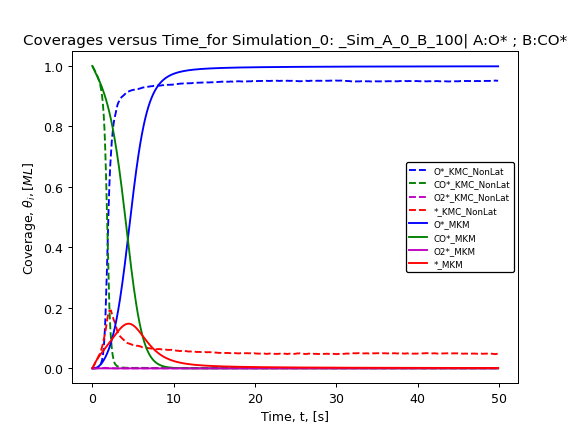

<IPython.core.display.Javascript object>


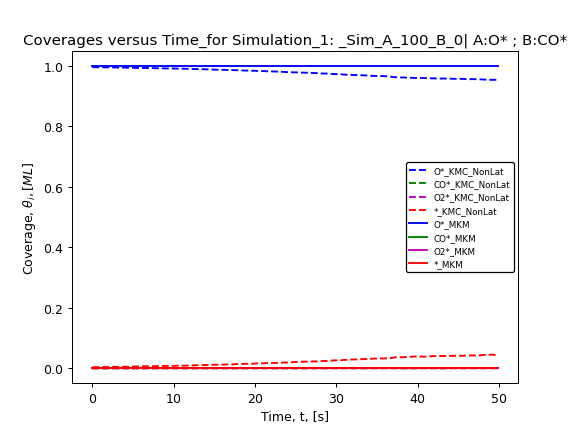

<IPython.core.display.Javascript object>


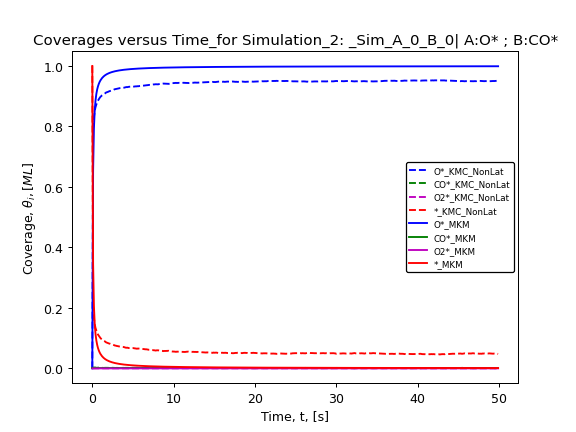

<IPython.core.display.Javascript object>


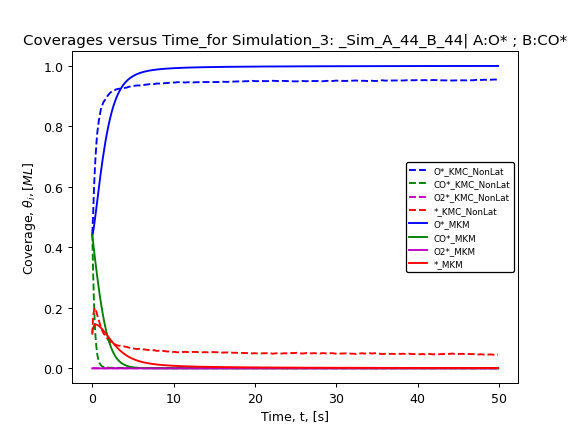

CPU times: user 97.4 ms, sys: 11.8 ms, total: 109 ms
Wall time: 108 ms


In [46]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

# Comp = 'iRates'
Comp = 'Covg'

colors = ['b','g','m','r','c','y','k'] 

# print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df_non['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        
        df_non = out_df_non.loc[out_df_non['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_non = df_non[[col for col in df_non if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        df_lat = out_df_lat.loc[out_df_lat['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_lat = df_lat[[col for col in df_lat if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        Time = df_non['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat_non[0,:])):
            ax.plot(Time, kmc_dat_non[:,i],colors[i]+'--')
            
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4] +'| A:O* ; B:CO*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4] +'| A:O* ; B:CO*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat_non = df_non[[col for col in df_non if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df_non['Time'].to_numpy()
            
            
        #Adding to the plot, MKM result : ------------------------------------------------     
        for i in np.arange(len(mkm_dat_non[0,:])):
            ax.plot(Time, mkm_dat_non[:,i],colors[i]+'-')
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC_NonLat" for string in leg_nd]+[f"{string}_MKM" for string in leg_nd],fontsize=7, loc='best',facecolor='white', edgecolor ='black', framealpha=1)


## SET 2: LATERAL KMC

Comparison of KMC vs fitted-k MKM results forCovg


<IPython.core.display.Javascript object>


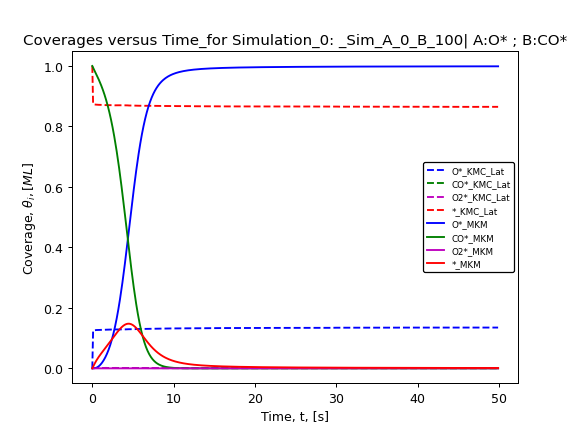

<IPython.core.display.Javascript object>


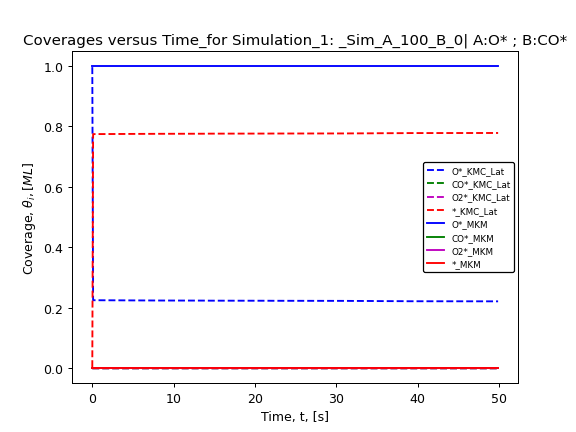

<IPython.core.display.Javascript object>


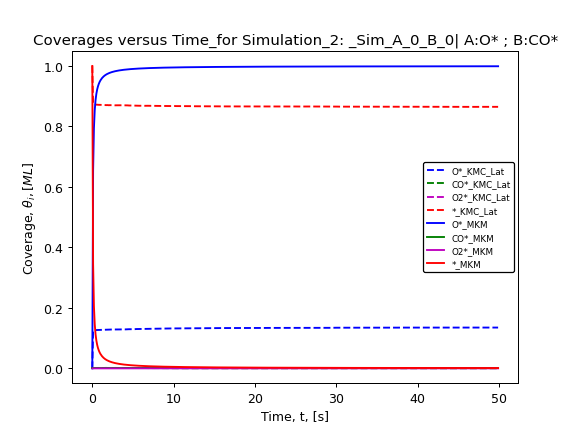

<IPython.core.display.Javascript object>


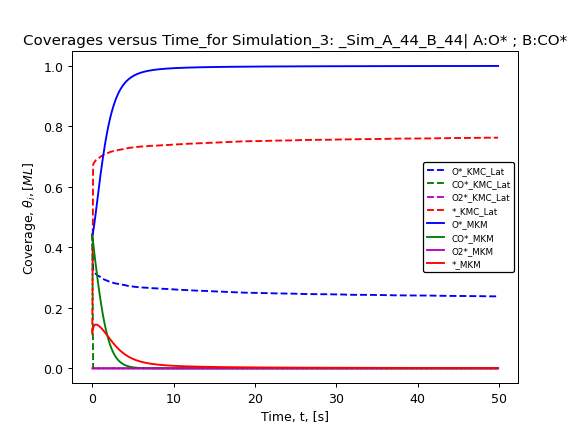

CPU times: user 94.6 ms, sys: 11.9 ms, total: 106 ms
Wall time: 111 ms


In [47]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

# Comp = 'iRates'
Comp = 'Covg'

print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df_non['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        df_non = out_df_non.loc[out_df_non['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_non = df_non[[col for col in df_non if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        df_lat = out_df_lat.loc[out_df_lat['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_lat = df_lat[[col for col in df_lat if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        df_lat_cd = out_df_lat_cd.loc[out_df_lat_cd['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        
        Time = df_non['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat_non[0,:])):
            ax.plot(Time, kmc_dat_lat[:,i],colors[i]+'--')
                        
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4]+'| A:O* ; B:CO*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4] +'| A:O* ; B:CO*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat_non = df_non[[col for col in df_non if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        mkm_dat_lat_cd = df_lat_cd[[col for col in df_lat_cd if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        mkm_dat_lat = df_lat[[col for col in df_lat if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df_non['Time'].to_numpy()
            
            
        #Adding to the plot, MKM result : ------------------------------------------------     
#         for i in np.arange(len(mkm_dat_non[0,:])):
#             ax.plot(Time, mkm_dat_non[:,i],'--')
        for i in np.arange(len(mkm_dat_non[0,:])):
            ax.plot(Time, mkm_dat_lat_cd[:,i],colors[i]+'-')
#         for i in np.arange(len(mkm_dat_non[0,:])):
#             ax.plot(Time, mkm_dat_lat[:,i],'^-')
            
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC_Lat" for string in leg_nd]+[f"{string}_MKM" for string in leg_nd],fontsize=7, loc='best',facecolor='white', edgecolor ='black', framealpha=1)


## NONLAT VS LAT

Comparison of KMC vs fitted-k MKM results forCovg


<IPython.core.display.Javascript object>


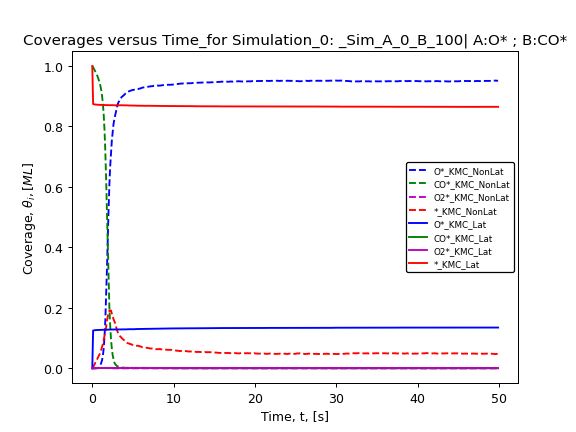

<IPython.core.display.Javascript object>


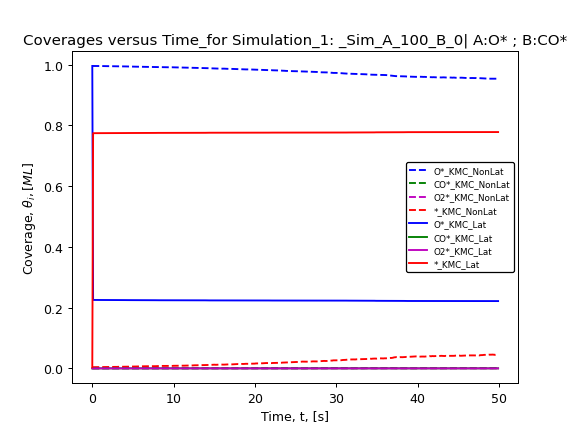

<IPython.core.display.Javascript object>


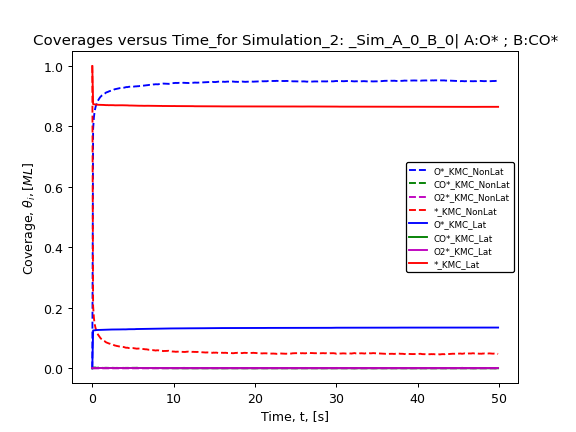

<IPython.core.display.Javascript object>


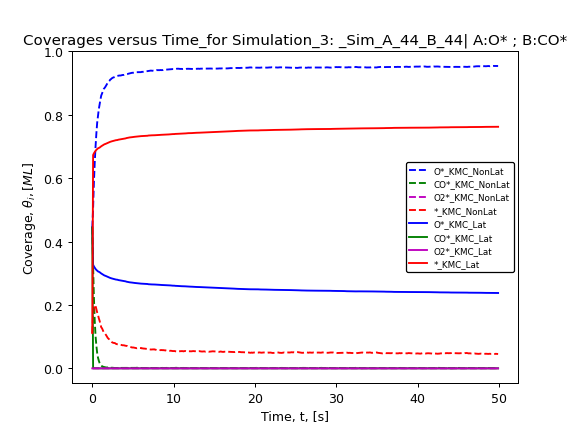

CPU times: user 94.8 ms, sys: 12.6 ms, total: 107 ms
Wall time: 104 ms


In [48]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

# Comp = 'iRates'
Comp = 'Covg'

print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df_non['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        df_non = out_df_non.loc[out_df_non['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_non = df_non[[col for col in df_non if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        df_lat = out_df_lat.loc[out_df_lat['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat_lat = df_lat[[col for col in df_lat if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        
        df_lat_cd = out_df_lat_cd.loc[out_df_lat_cd['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        
        Time = df_non['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat_non[0,:])):
            ax.plot(Time, kmc_dat_non[:,i],colors[i]+'--')
        for i in np.arange(len(kmc_dat_non[0,:])):
            ax.plot(Time, kmc_dat_lat[:,i],colors[i]+'-')
                        
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4]+'| A:O* ; B:CO*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df_non['Sim_ndex'].iloc[i] +': _'+df_non['Sim_names'].iloc[0][:-4] +'| A:O* ; B:CO*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat_non = df_non[[col for col in df_non if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        mkm_dat_lat_cd = df_lat_cd[[col for col in df_lat_cd if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        mkm_dat_lat = df_lat[[col for col in df_lat if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df_non['Time'].to_numpy()
            
            
#         #Adding to the plot, MKM result : ------------------------------------------------     
#         for i in np.arange(len(mkm_dat_non[0,:])):
#             ax.plot(Time, mkm_dat_non[:,i],'x-')
#             ax.plot(Time, mkm_dat_lat[:,i],'c-')
#             ax.plot(Time, mkm_dat_lat_cd[:,i],'c--')
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC_NonLat" for string in leg_nd]+ [f"{string}_KMC_Lat" for string in leg_nd],fontsize=7, loc='best',facecolor='white', edgecolor ='black', framealpha=1)


# ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- ----------------------------------------------------------- -----------------------------------------------------------